## Lesson 2: Langgraph Components

In [1]:
%pip install dotenv langchain-core langchain_openai langchain_community langgraph pygraphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [4]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [6]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_llm)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: 'action', False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_llm(self, state:AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def take_action(self, state:AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for tool in tool_calls:
            print(f"Calling: {tool}")
            if not tool['name'] in self.tools:
                print("\n ...bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[tool['name']].invoke(tool['args'])
            results.append(ToolMessage(tool_call_id=tool['id'], name=tool['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}


In [7]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [12]:
import os

# using groq api
open_ai_key = os.getenv('OPEN_API_KEY')
open_ai_base_url = "https://api.groq.com/openai/v1"
model = ChatOpenAI(model = 'llama3-8b-8192', api_key=open_ai_key, base_url=open_ai_base_url)

In [13]:
# initiate the agent

abot = Agent(model, [tool], system=prompt)

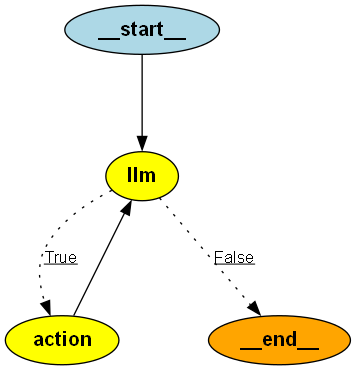

In [14]:
# visualize the agent

from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [15]:
messages = [HumanMessage(content="Who won the the Champions Trophy 2025, and how many times did it won before?")]
result = abot.graph.invoke({'messages': messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Champions Trophy 2025 winners'}, 'id': 'call_kjn3', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the Champions Trophy 2025 and how many times did it win before?'}, 'id': 'call_btd7', 'type': 'tool_call'}
Back to the model!


In [16]:
result

{'messages': [HumanMessage(content='Who won the the Champions Trophy 2025, and how many times did it won before?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kjn3', 'function': {'arguments': '{"query":"Champions Trophy 2025 winners"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 83, 'prompt_tokens': 1026, 'total_tokens': 1109, 'completion_tokens_details': None, 'prompt_tokens_details': None, 'queue_time': 0.048322504000000016, 'prompt_time': 0.151044185, 'completion_time': 0.069166667, 'total_time': 0.220210852}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_179b0f92c9', 'id': 'chatcmpl-cbe6df85-5def-4c8a-b6e4-79ef49de0b36', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9a7dbcb1-f51e-443b-9482-fe9a920f7ea2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'Champions Trophy 2025 

In [17]:
result['messages'][-1].content

'India won the Champions Trophy 2025 and has won the tournament three times before, in 2002 (shared with Sri Lanka) and 2013 (defeated England in the final).'